In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'
os.listdir(FOLDER)

['mulliken_charges.csv',
 'sample_submission.csv',
 'magnetic_shielding_tensors.csv',
 'train.csv',
 'test.csv',
 'dipole_moments.csv',
 'potential_energy.csv',
 'structures.csv',
 'out',
 'scalar_coupling_contributions.csv',
 'dsgdb9nsd_000001.xyz',
 'structures.zip']

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

to find target bonding

In [4]:
def assign_atoms_index(df, molecule):
    se_0 = df.query('molecule_name == "{}"'.format(molecule))['atom_index_0']
    se_1 = df.query('molecule_name == "{}"'.format(molecule))['atom_index_1']
    se = pd.concat([se_0, se_1])
    return se.unique()

get distance between target atom and other surrounding atoms. Colomb interaction is propotional squared inverse 

In [5]:
def gen_dist_matrix(df_structure, mole_name, assigned_atoms_idx, num):
    atoms = ['H', 'C', 'N', 'O', 'F']
    dist_matrix_list = []
    for atom_idx0 in assigned_atoms_idx:
        loc0 = df_structures.query('molecule_name == "{}" and atom_index == {}'.format(mole_name, atom_idx0))[['x','y','z']].values.reshape(-1)
        atom_name0 = df_structures.query('molecule_name == "{}" and atom_index == {}'.format(mole_name, atom_idx0))['atom'].values[0] 
        
        atom_mole = df_structures.query('molecule_name == "{}"'.format(mole_name))['atom_index'].values
        mask = atom_mole != atom_idx0
        atom_idx_excl0 = atom_mole[mask]

        dist_list = []
        atom_list = []
        for i in atom_idx_excl0:
            loc1 = df_structures.query('molecule_name == "{}" and atom_index == {}'.format(mole_name, i))[['x','y','z']].values.reshape(-1)
            atom_name1 = df_structures.query('molecule_name == "{}" and atom_index == {}'.format(mole_name, i))['atom'].values[0]
            dist_list.append(1.0 / sum((loc0 - loc1)**2))
            atom_list.append(atom_name1)

        dist_arr = np.array(dist_list)
        atom_arr = np.array(atom_list)

        dist_arr_sorted = -np.sort(-dist_arr)
        atom_arr_sorted = atom_arr[np.argsort(-dist_arr)]

        dist_matrix = np.zeros([len(atoms), num])
        for j, atom in enumerate(atoms):
            len_sorted = len(dist_arr_sorted[atom_arr_sorted == atom])
            if num < len_sorted:
                dist_matrix[j, :] = dist_arr_sorted[atom_arr_sorted == atom][:num]
            else:
                dist_matrix[j, :len_sorted] = dist_arr_sorted[atom_arr_sorted == atom]

        dist_matrix_list.append(dist_matrix.reshape(-1))
    return np.array(dist_matrix_list)

In [ ]:
num = 5
mole_names = list(df_train['molecule_name'].value_counts().index)[:1000]
dist_mat = np.zeros([0, num*5])
atoms_idx = np.zeros([0], dtype=np.int32)
molecule_names = np.empty([0])

start = time.time()

for name in mole_names:
    assigned_atoms_idx = assign_atoms_index(df_train, name)
    dist_mat_mole = gen_dist_matrix(df_structures, name, assigned_atoms_idx, num)
    name_arr = [name] * len(assigned_atoms_idx) 
    
    molecule_names = np.hstack([molecule_names, name_arr])
    atoms_idx = np.hstack([atoms_idx, assigned_atoms_idx])
    dist_mat = np.vstack([dist_mat, dist_mat_mole])
    
col_name_list = []
atoms = ['H', 'C', 'N', 'O', 'F']
for a in atoms:
    for n in range(num):
        col_name_list.append('dist_{}_{}'.format(a, n))
        
se_mole = pd.Series(molecule_names, name='molecule_name')
se_atom_idx = pd.Series(atoms_idx, name='atom_index')
df_dist = pd.DataFrame(dist_mat, columns=col_name_list)
df_distance = pd.concat([se_mole, se_atom_idx,df_dist], axis=1)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [ ]:
df_distance.to_csv(OUTPUT + 'distance1000.csv', index=False)

In [58]:
df_dist1 = pd.read_csv(OUTPUT + 'distance1000.csv')
# df_dist2 = pd.read_csv(OUTPUT + 'distance2000.csv')
# df_dist3 = pd.read_csv(OUTPUT + 'distance3000.csv')
df_dist = pd.concat([df_dist1, df_dist2, df_dist3], axis=0)

In [193]:
mols = df_dist['molecule_name'].value_counts().index
df_train_ext = df_train[df_train['molecule_name'].isin(mols)]

In [194]:
df_train_temp = df_train_ext.query('molecule_name == "{}"'.format(m))

In [195]:
df_train_temp.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
1531758,1531758,dsgdb9nsd_049709,9,1,1JHC,106.960000
1531759,1531759,dsgdb9nsd_049709,9,2,2JHC,29.062700
1531760,1531760,dsgdb9nsd_049709,9,3,3JHC,-0.279606
1531761,1531761,dsgdb9nsd_049709,9,6,3JHC,3.193280
1531762,1531762,dsgdb9nsd_049709,9,10,3JHH,0.763431


In [197]:
len(mols)

1911

In [198]:
dist_arr = np.zeros([0, num*5*2])
mole_arr = np.zeros([0])
type_arr = np.zeros([0])
atom_idx_arr = np.zeros([0,2])
sc_const_arr = np.zeros([0])

for m in mols:
    df_train_temp = df_train_ext.query('molecule_name == "{}"'.format(m))
    len_temp = df_train_temp.shape[0]
    for i in range(len_temp):
        atom0 = df_train_temp['atom_index_0'].values[i]
        atom1 = df_train_temp['atom_index_1'].values[i]

        type_conn = df_train_temp['type'].values[i]
        type_arr = np.hstack([type_arr, type_conn])
        
        sc_const = df_train_temp['scalar_coupling_constant'].values[i]
        sc_const_arr = np.hstack([sc_const_arr, sc_const])
        
        mole_arr = np.hstack([mole_arr, m])
        atom_idx_arr = np.vstack([atom_idx_arr, [atom0, atom1]])

        df_dist_temp =  df_dist.query('molecule_name == "{}"'.format(m))
        dist_arr0 = df_dist_temp.query('atom_index == {}'.format(atom0)).values[0, 2:].astype(np.float32)
        dist_arr1 = df_dist_temp.query('atom_index == {}'.format(atom1)).values[0, 2:].astype(np.float32)
        dist_arr_bond = np.hstack([dist_arr0, dist_arr1])
        dist_arr = np.vstack([dist_arr, dist_arr_bond])

KeyboardInterrupt: 

In [199]:
len(sc_const_arr)

133860

In [200]:
df_dist_arr_temp = pd.DataFrame(dist_arr)
se_type_arr = pd.Series(type_arr, name='type')
se_mole_arr = pd.Series(mole_arr, name='molecule_name')
se_sc_const_arr = pd.Series(sc_const_arr, name='scalar_coupling_constant')
df_atom_idx = pd.DataFrame(atom_idx_arr, columns=['atom_index_0', 'atom_index_1'])
df_train_dist = pd.concat([se_mole_arr, df_atom_idx, se_type_arr, se_sc_const_arr, df_dist_arr_temp], axis=1)

In [202]:
df_1JHC = df_train_dist.query('type == "1JHC"')
y = df_1JHC['scalar_coupling_constant'].values
X = df_1JHC[df_1JHC.columns[5:]].values
print(X.shape)
print(y.shape)

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [218]:
mlp = MLPRegressor(hidden_layer_sizes=(100,50))
mlp.fit(X_train, y_train)

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 50), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [219]:
y_pred = mlp.predict(X_val)

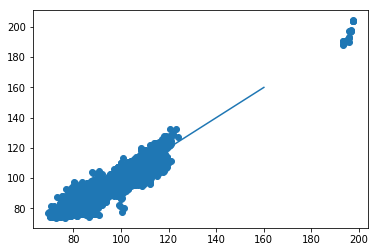

In [220]:
plt.scatter(y_val, y_pred)
plt.title('1JCH')
plt.plot([80, 200], [80, 200])
plt.show()